In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import argparse
import time

import sys
sys.path.append('../..')
from data.dataloader import get_covid19india_api_data
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.fitting import get_all_district_data, data_setup, run_cycle
from main.seir.forecast import create_all_csvs, write_csv, plot_forecast

In [54]:
def backtesting(df_district, df_district_raw_data, increment=5, future_days=10, optimize_runs=3, max_evals=100, train_period=7, val_period=7):
    runtime_s = time.time()
    start = pd.to_datetime(df_district['date']).min()
    end = pd.to_datetime(df_district['date']).max()
    print(start, end)
    n_days = (end - start).days + 1 - future_days
    # model = model.generate()
    results = {}
    seed = datetime.today().timestamp()
    for run_day in range(train_period + val_period + 1, n_days, increment):
        end_date = pd.to_datetime(df_district['date'], format='%Y-%m-%d').loc[run_day]
        print ("\rbacktesting for", end_date, end="")

        #  TRUNCATE DATA
        df_district_incr = df_district[pd.to_datetime(df_district['date'], format='%Y-%m-%d') <= end_date]
        df_district_raw_data_incr = df_district_raw_data[pd.to_datetime(df_district_raw_data['date'], format='%Y-%m-%d') <= end_date]
        
        df_district_incr, df_district_raw_data_incr, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = \
            data_setup(df_district_incr, df_district_raw_data_incr, pre_lockdown, train_on_val, val_period)
        
        # FIT/PREDICT
        res = run_cycle(
            state, district, df_district_incr, df_district_raw_data_incr, df_train, df_val, df_train_nora, df_val_nora,
            train_period=train_period, train_on_val=train_on_val, num_evals=num_evals, N=N, 
            which_compartments=which_compartments, initialisation=initialisation
        )

        results[end_date] = {
            'n_days': n_days,
            'seed': seed,
            'results': res,
        }
    runtime = time.time() - runtime_s
    print (runtime)
    out = {
        'results': results,
        'df_district': df_district,
        'future_days': future_days,
        'runtime': runtime,
    }
    return out

In [31]:
dataframes = get_covid19india_api_data()


In [51]:
state, district = 'Maharashtra', 'Pune'
fit = 'm1' # 'm1' or 'm2'
data_from_tracker=False

In [52]:
train_period = 7
N = 1e7
pre_lockdown = False
initialisation = 'intermediate'
which_compartments = ['hospitalised', 'total_infected', 'deceased', 'recovered']

val_period = 7 if fit is 'm1' else 0
train_on_val = False if fit is 'm1' else True
num_evals = 700 if data_from_tracker else 1000

if district == 'Mumbai':
    data_format = 'old'
    filepath = '../../data/data/official-mumbai.csv'
elif district == 'Pune':
    data_format = 'new'
    filepath = '../../data/data/official-pune-21-05-20.csv'

In [34]:
df_district, df_district_raw_data = get_all_district_data(dataframes, state, district, 
                data_from_tracker, data_format, filepath)

2020-04-19 00:00:00 2020-05-18 00:00:00
backtesting for 2020-05-04 00:00:00splitting data ..
splitting data ..
7 7
100%|██████████| 1000/1000 [02:15<00:00,  7.40trial/s, best loss: 5.3249738336987935]
best parameters
 {'E_hosp_ratio': 0.6736251643487247, 'I_hosp_ratio': 0.42394732006837665, 'P_fatal': 0.1537084202117348, 'P_severe': 0.8303119410337281, 'T_inc': 4.279228127707672, 'T_inf': 3.2523191780438103, 'T_recov_severe': 40.72346707488492, 'lockdown_R0': 1.3878841033367606}
backtesting for 2020-05-07 00:00:00splitting data ..
splitting data ..
10 7
100%|██████████| 1000/1000 [02:21<00:00,  7.05trial/s, best loss: 4.090601087335591]
best parameters
 {'E_hosp_ratio': 0.5611546245947784, 'I_hosp_ratio': 0.47891516658537603, 'P_fatal': 0.10740278120472595, 'P_severe': 0.6596108698021141, 'T_inc': 4.0510885639968475, 'T_inf': 3.126255074867516, 'T_recov_severe': 59.99641992309665, 'lockdown_R0': 1.1486229959748697}
backtesting for 2020-05-10 00:00:00splitting data ..
splitting data ..


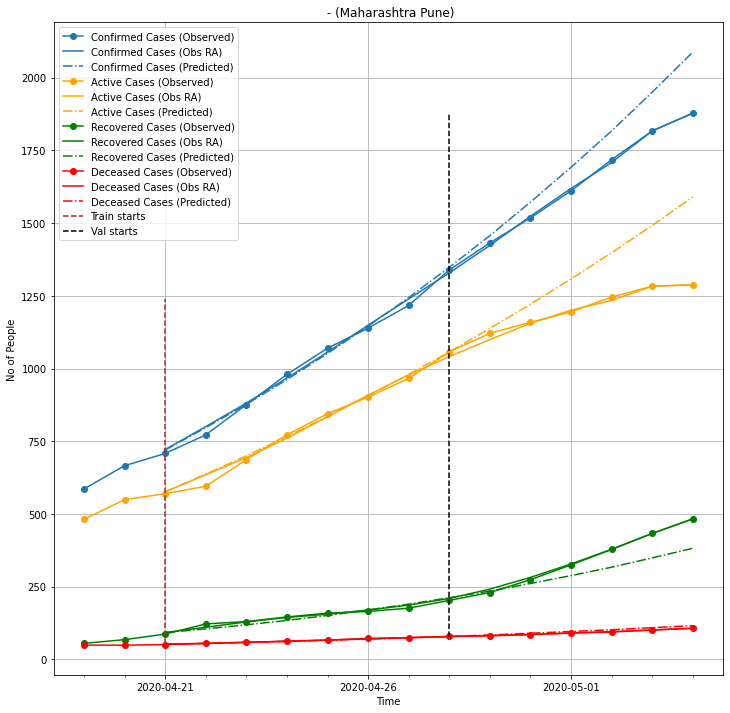

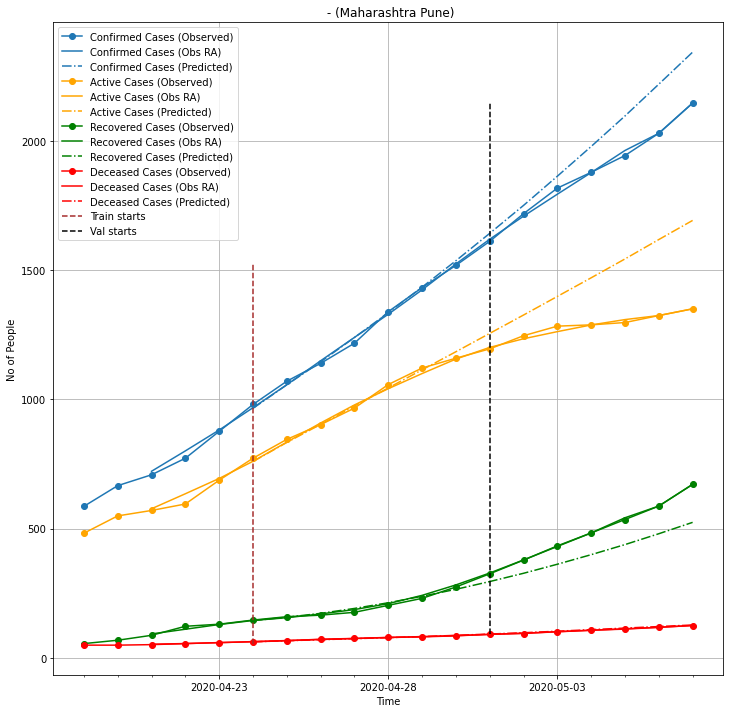

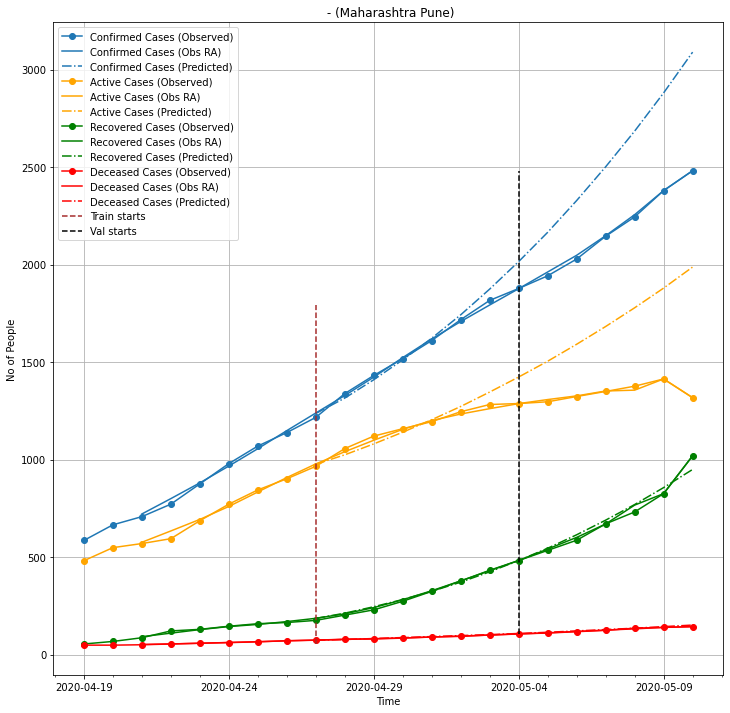

In [55]:
out = backtesting(df_district, df_district_raw_data, future_days=7, increment=3, train_period=train_period, val_period=val_period)

In [56]:
out['results'].keys()

dict_keys([15, 18, 21])

In [59]:
for run in out['results'].keys():
    print(out['results'][run]['results']['df_loss'])
    # print(out['results'][run]['results']['df_prediction'])

train      val
hospitalised    1.90617  8.44075
total_infected  1.61155  4.70463
deceased        1.12224  5.32522
recovered       7.91883  13.4218
                   train      val
hospitalised     1.15293  12.2496
total_infected  0.970111  5.07305
deceased         1.28699  2.21268
recovered        3.71976  19.8461
                  train      val
hospitalised    2.46112   20.154
total_infected  1.51267  13.9577
deceased        2.37515  2.81907
recovered       3.32153  3.60598
